<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/22nd%20May%20April%20Feval%20Lgbm%20Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from sklearn.multioutput import RegressorChain


import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [3]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [4]:
train.shape, target.shape, test.shape

((6524, 22), (6524, 3), (4423, 22))

In [5]:
for i in train.columns:
    print(i, train[i].nunique())

Moons 14
id 6524
Feature_1 5
Feature_2 5
Feature_3 4
Feature_4 5
Feature_5 5
Feature_6 5
Feature_7 5
Feature_8 5
Feature_9 5
Feature_10 5
Feature_11 5
Feature_12 5
Feature_13 5
Feature_14 5
Feature_15 5
Feature_16 5
Feature_17 5
Feature_19 5
Feature_20 5
Feature_21 5


In [6]:
for i in test.columns:
    print(i, test[i].nunique())

Moons 9
id 4423
Feature_1 5
Feature_2 5
Feature_3 4
Feature_4 5
Feature_5 5
Feature_6 5
Feature_7 5
Feature_8 5
Feature_9 5
Feature_10 5
Feature_11 5
Feature_12 5
Feature_13 5
Feature_14 5
Feature_15 5
Feature_16 5
Feature_17 5
Feature_19 5
Feature_20 5
Feature_21 5


In [7]:
cat_feature = []
for i in train.columns:
    val = train[i].value_counts()
    if val.shape[0] == 2:
        cat_feature.append(i)
cat_feature

[]

In [8]:
all_features = [f for f in train.columns if "Feature" in f]

In [9]:
num_features = [f for f in all_features if f not in cat_feature]

In [10]:
num_features

['Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'Feature_6',
 'Feature_7',
 'Feature_8',
 'Feature_9',
 'Feature_10',
 'Feature_11',
 'Feature_12',
 'Feature_13',
 'Feature_14',
 'Feature_15',
 'Feature_16',
 'Feature_17',
 'Feature_19',
 'Feature_20',
 'Feature_21']

In [11]:
def add_features(df):
    for f in df[num_features].columns:
        df['pos_'+str(f)] = df[f]+abs(df[f].min())+1
    for f in [f for f in df.columns if "pos" in f]:
        df['log_'+str(f[4:])] = np.log(df[str(f)])
    for f in [f for f in df.columns if "pos" in f]:
        df['sqrt_'+str(f[4:])] = np.sqrt(df[str(f)])
    df.drop(columns = [f for f in df.columns if "pos" in f], inplace=True)
    return df

In [12]:
train = add_features(train)
test = add_features(test)

In [13]:
ocorr = (train.corrwith(target.target_r).abs() + train.corrwith(target.target_g).abs() + train.corrwith(target.target_b).abs() )/3
ocorr.sort_values(ascending=False)

log_Feature_2      0.106625
sqrt_Feature_2     0.106500
Feature_2          0.106044
Feature_13         0.100009
sqrt_Feature_13    0.098821
                     ...   
sqrt_Feature_4     0.010956
log_Feature_4      0.010252
log_Feature_5      0.008068
sqrt_Feature_5     0.007657
Feature_5          0.007174
Length: 61, dtype: float64

# Mutual Information

In [14]:
train.head()

,Moons,id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_19,Feature_20,Feature_21,log_Feature_1,log_Feature_2,log_Feature_3,log_Feature_4,log_Feature_5,log_Feature_6,log_Feature_7,log_Feature_8,log_Feature_9,log_Feature_10,log_Feature_11,log_Feature_12,log_Feature_13,log_Feature_14,log_Feature_15,log_Feature_16,log_Feature_17,log_Feature_19,log_Feature_20,log_Feature_21,sqrt_Feature_1,sqrt_Feature_2,sqrt_Feature_3,sqrt_Feature_4,sqrt_Feature_5,sqrt_Feature_6,sqrt_Feature_7,sqrt_Feature_8,sqrt_Feature_9,sqrt_Feature_10,sqrt_Feature_11,sqrt_Feature_12,sqrt_Feature_13,sqrt_Feature_14,sqrt_Feature_15,sqrt_Feature_16,sqrt_Feature_17,sqrt_Feature_19,sqrt_Feature_20,sqrt_Feature_21
0,0,0xd11efd10c7cc3099,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.50,0.25,0.50,0.50,0.75,0.75,0.75,0.75,0.405465,0.000000,0.000000,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.559616,0.405465,0.223144,0.405465,0.405465,0.559616,0.559616,0.559616,0.559616,1.224745,1.000000,1.000000,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.322876,1.224745,1.118034,1.224745,1.224745,1.322876,1.322876,1.322876,1.322876
1,0,0x638cf8491e2531e1,0.50,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.405465,0.000000,0.559616,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.224745,1.000000,1.322876,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0,0x79acc91873477033,0.75,0.5,0.25,1.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,1.00,0.75,0.50,0.25,0.75,0.25,0.50,1.00,0.75,0.559616,0.405465,0.223144,0.693147,0.559616,0.0,0.0,0.0,0.0,0.405465,0.405465,0.693147,0.559616,0.405465,0.223144,0.559616,0.223144,0.405465,0.693147,0.559616,1.322876,1.224745,1.118034,1.414214,1.322876,1.0,1.0,1.0,1.0,1.224745,1.224745,1.414214,1.322876,1.224745,1.118034,1.322876,1.118034,1.224745,1.414214,1.322876
3,0,0x1c460564096ec677,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.75,0.50,0.75,0.75,0.50,0.50,0.75,0.50,0.405465,0.000000,0.000000,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.405465,0.559616,0.405465,0.559616,0.559616,0.405465,0.405465,0.559616,0.405465,1.224745,1.000000,1.000000,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.224745,1.322876,1.224745,1.322876,1.322876,1.224745,1.224745,1.322876,1.224745
4,0,0x4ee26947ed8f9add,0.75,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.559616,0.000000,0.559616,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.322876,1.000000,1.322876,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df = train.drop(columns=['Moons', 'id'])

In [16]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_19,Feature_20,Feature_21,log_Feature_1,log_Feature_2,log_Feature_3,log_Feature_4,log_Feature_5,log_Feature_6,log_Feature_7,log_Feature_8,log_Feature_9,log_Feature_10,log_Feature_11,log_Feature_12,log_Feature_13,log_Feature_14,log_Feature_15,log_Feature_16,log_Feature_17,log_Feature_19,log_Feature_20,log_Feature_21,sqrt_Feature_1,sqrt_Feature_2,sqrt_Feature_3,sqrt_Feature_4,sqrt_Feature_5,sqrt_Feature_6,sqrt_Feature_7,sqrt_Feature_8,sqrt_Feature_9,sqrt_Feature_10,sqrt_Feature_11,sqrt_Feature_12,sqrt_Feature_13,sqrt_Feature_14,sqrt_Feature_15,sqrt_Feature_16,sqrt_Feature_17,sqrt_Feature_19,sqrt_Feature_20,sqrt_Feature_21
0,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.50,0.25,0.50,0.50,0.75,0.75,0.75,0.75,0.405465,0.000000,0.000000,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.559616,0.405465,0.223144,0.405465,0.405465,0.559616,0.559616,0.559616,0.559616,1.224745,1.000000,1.000000,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.322876,1.224745,1.118034,1.224745,1.224745,1.322876,1.322876,1.322876,1.322876
1,0.50,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.405465,0.000000,0.559616,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.224745,1.000000,1.322876,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.75,0.5,0.25,1.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,1.00,0.75,0.50,0.25,0.75,0.25,0.50,1.00,0.75,0.559616,0.405465,0.223144,0.693147,0.559616,0.0,0.0,0.0,0.0,0.405465,0.405465,0.693147,0.559616,0.405465,0.223144,0.559616,0.223144,0.405465,0.693147,0.559616,1.322876,1.224745,1.118034,1.414214,1.322876,1.0,1.0,1.0,1.0,1.224745,1.224745,1.414214,1.322876,1.224745,1.118034,1.322876,1.118034,1.224745,1.414214,1.322876
3,0.50,0.0,0.00,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.75,0.50,0.75,0.75,0.50,0.50,0.75,0.50,0.405465,0.000000,0.000000,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.405465,0.559616,0.405465,0.559616,0.559616,0.405465,0.405465,0.559616,0.405465,1.224745,1.000000,1.000000,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.224745,1.322876,1.224745,1.322876,1.322876,1.224745,1.224745,1.322876,1.224745
4,0.75,0.0,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.559616,0.000000,0.559616,0.693147,0.559616,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.322876,1.000000,1.322876,1.414214,1.322876,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
from sklearn.feature_selection import mutual_info_regression

In [18]:
mi_scores_r = mutual_info_regression(df, target.target_r)
mi_scores_g = mutual_info_regression(df, target.target_g)
mi_scores_b = mutual_info_regression(df, target.target_b)

mi_scores = pd.Series((mi_scores_r + mi_scores_g +  mi_scores_b)/3, name="MI Scores", index=df.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

sqrt_Feature_3     0.023514
log_Feature_3      0.021480
log_Feature_2      0.014832
Feature_2          0.013672
sqrt_Feature_12    0.011388
Feature_14         0.010868
sqrt_Feature_15    0.010619
log_Feature_20     0.010348
sqrt_Feature_2     0.009956
log_Feature_21     0.009795
Feature_13         0.009762
Feature_16         0.009754
Feature_1          0.009513
sqrt_Feature_7     0.009114
log_Feature_13     0.009067
log_Feature_8      0.009020
log_Feature_19     0.009005
Feature_19         0.008477
Feature_17         0.008451
sqrt_Feature_13    0.008315
log_Feature_10     0.007895
Feature_9          0.007494
log_Feature_12     0.007284
Feature_4          0.007244
sqrt_Feature_19    0.006982
Feature_20         0.006457
log_Feature_5      0.006379
sqrt_Feature_10    0.005453
Feature_6          0.005429
log_Feature_14     0.005355
sqrt_Feature_21    0.004869
Feature_12         0.004865
log_Feature_16     0.004770
log_Feature_1      0.004737
log_Feature_17     0.004699
sqrt_Feature_11    0

In [30]:
# df = train.copy(deep=True)

In [20]:
sqrt_feature = [f for f in df.columns if "sqrt" in f]
log_feature= [f for f in df.columns if "log" in f]
sqrt_log_feature = sqrt_feature + log_feature
sqrt_log_feature

['sqrt_Feature_1',
 'sqrt_Feature_2',
 'sqrt_Feature_3',
 'sqrt_Feature_4',
 'sqrt_Feature_5',
 'sqrt_Feature_6',
 'sqrt_Feature_7',
 'sqrt_Feature_8',
 'sqrt_Feature_9',
 'sqrt_Feature_10',
 'sqrt_Feature_11',
 'sqrt_Feature_12',
 'sqrt_Feature_13',
 'sqrt_Feature_14',
 'sqrt_Feature_15',
 'sqrt_Feature_16',
 'sqrt_Feature_17',
 'sqrt_Feature_19',
 'sqrt_Feature_20',
 'sqrt_Feature_21',
 'log_Feature_1',
 'log_Feature_2',
 'log_Feature_3',
 'log_Feature_4',
 'log_Feature_5',
 'log_Feature_6',
 'log_Feature_7',
 'log_Feature_8',
 'log_Feature_9',
 'log_Feature_10',
 'log_Feature_11',
 'log_Feature_12',
 'log_Feature_13',
 'log_Feature_14',
 'log_Feature_15',
 'log_Feature_16',
 'log_Feature_17',
 'log_Feature_19',
 'log_Feature_20',
 'log_Feature_21']

In [28]:
# power_corr = []
# df_s = pd.DataFrame()
# for i in np.linspace(2, 20, 50):
#     # print(i)
#     for f in sqrt_log_feature:
#         # print(f)
#         df_s[f'power_{i}' +str(f)] = np.power(train[f], i)
#     c_r = df_s.corrwith(target.target_r).abs()
#     c_g = df_s.corrwith(target.target_g).abs()
#     c_b = df_s.corrwith(target.target_b).abs()
#     power_corr.append((c_r + c_g + c_b)/3)
# pd.concat(power_corr).sort_values(ascending=False).drop_duplicates()

In [15]:
# from sklearn.preprocessing import PolynomialFeatures
# def polynomial_features(df):

#     poly = PolynomialFeatures(degree=3, interaction_only=True,include_bias=False)
#     # sqrt_feature = [f for f in df.columns if "sqrt" in f]
#     # log_feature= [f for f in df.columns if "log" in f]
#     # sqrt_log_feature = sqrt_feature + log_feature
#     emb = poly.fit_transform(df[num_features].values)
#     poly_df = pd.DataFrame(emb, columns=[f'poly_{i}' for i in  range(emb.shape[1]) ])
#     concat_df = pd.concat([df, poly_df], axis=1)
#     return concat_df

In [16]:
# train_df = polynomial_features(train)
# test_df = polynomial_features(test)

In [31]:
corr_r = df.corrwith(target.target_r).abs()
corr_g = df.corrwith(target.target_g).abs()
corr_b = df.corrwith(target.target_b).abs()
overall_corr = (corr_r + corr_g + corr_b)/3
overall_corr.sort_values(ascending=False, inplace=True)
# corr_feat = overall_corr[overall_corr > 0.135].index.tolist()

In [32]:
overall_corr.describe()

count    60.000000
mean      0.043562
std       0.030442
min       0.007174
25%       0.020947
50%       0.029502
75%       0.063797
max       0.106625
dtype: float64

In [20]:
# corr_feat = overall_corr[overall_corr > 0.05].index.tolist()
# len(corr_feat)

In [34]:
!pip install optuna

In [35]:
def spearman_r(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_r', score, True
def spearman_g(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_g', score, True
def spearman_b(preds, dtrain):
    labels = dtrain.get_label()
    score = stats.spearmanr(labels, preds)[0]
    return 'spearman_b', score, True

In [30]:
# train = train_df[corr_feat]
# test = test_df[corr_feat]

In [38]:
%%time
import optuna
X =  df
y = target

N_TRIALS = 200
def objective(trial):    
    
    params = {
    'num_leaves': trial.suggest_int('num_leaves', 4, 64),
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'custom',
    'max_depth': trial.suggest_int('max_depth', 4, 16),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
    'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
    'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
    'max_bin': trial.suggest_int('max_bin', 50, 900),
    'early_stopping_rounds': 100, 
    }


    oof_pred_r = np.zeros(len(X))
    oof_pred_g = np.zeros(len(X))
    oof_pred_b = np.zeros(len(X))
    kf = KFold(n_splits=3, random_state=60)
    
    cnt = 1
    for tr_ind , val_ind in kf.split(X, y):
        # print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
        
        X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
        y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]

        tr_data_r = lgb.Dataset(X_train, y_train.target_r)
        va_data_r = lgb.Dataset(X_val, y_val.target_r)

        tr_data_g = lgb.Dataset(X_train, y_train.target_g)
        va_data_g = lgb.Dataset(X_val, y_val.target_g)

        tr_data_b = lgb.Dataset(X_train, y_train.target_b)
        va_data_b = lgb.Dataset(X_val, y_val.target_b)
        
        model_r = lgb.train(params, tr_data_r, valid_sets=[tr_data_r, va_data_r], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_r)
        # print(model_r)
        model_g = lgb.train(params, tr_data_g, valid_sets=[tr_data_g, va_data_g], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval= spearman_g)
        # print(model_g)
        model_b = lgb.train(params, tr_data_b, valid_sets=[tr_data_b, va_data_b], verbose_eval=None, num_boost_round=5000, 
                            early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_b)
        # print(model_b)
        # print(" ")

        val_pred_r = model_r.predict(X_val)
        val_pred_g = model_g.predict(X_val)
        val_pred_b = model_b.predict(X_val)

        oof_pred_r[val_ind] = val_pred_r
        oof_pred_g[val_ind] = val_pred_g
        oof_pred_b[val_ind] = val_pred_b


        cnt += 1
    oof_pred_df = pd.concat([pd.DataFrame(oof_pred_r, columns=['target_r']),
                        pd.DataFrame(oof_pred_g, columns=['target_g']),
                        pd.DataFrame(oof_pred_b, columns=['target_b'])], axis=1)

    # display(oof_pred_df)
    score_r = stats.spearmanr(oof_pred_df.target_r, target.target_r)[0]
    score_g = stats.spearmanr(oof_pred_df.target_g, target.target_g)[0]
    score_b = stats.spearmanr(oof_pred_df.target_b, target.target_b)[0]

    score = (score_r+score_g+score_b)/ 3
    from google.colab import output
    output.clear()
    return score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
display(study.best_params)
display(study.best_trial.value)

[I 2021-05-22 08:20:50,964] Trial 199 finished with value: 0.08084509858060702 and parameters: {'num_leaves': 6, 'max_depth': 9, 'min_child_weight': 14, 'feature_fraction': 0.41309708157571956, 'bagging_fraction': 0.41104604135941647, 'bagging_freq': 1, 'min_child_samples': 79, 'lambda_l1': 5.413966461972347e-05, 'lambda_l2': 0.00013671829859636516, 'learning_rate': 0.80625157699583, 'max_bin': 687}. Best is trial 148 with value: 0.09108393629621109.



{'bagging_fraction': 0.4272566287659833,
 'bagging_freq': 1,
 'feature_fraction': 0.4729223007771801,
 'lambda_l1': 0.00015418519770650656,
 'lambda_l2': 0.00042137100905065386,
 'learning_rate': 0.8079518111090697,
 'max_bin': 621,
 'max_depth': 7,
 'min_child_samples': 77,
 'min_child_weight': 13,
 'num_leaves': 4}

0.09108393629621109

CPU times: user 1h 12min 9s, sys: 20 s, total: 1h 12min 29s
Wall time: 18min 35s


In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'custom',
    
    'bagging_fraction': 0.4272566287659833,
 'bagging_freq': 1,
 'feature_fraction': 0.4729223007771801,
 'lambda_l1': 0.00015418519770650656,
 'lambda_l2': 0.00042137100905065386,
 'learning_rate': 0.8079518111090697,
 'max_bin': 621,
 'max_depth': 7,
 'min_child_samples': 77,
 'min_child_weight': 13,
 'num_leaves': 4
 }

X =  df
y = target

# test = test.drop(columns=['Moons', "id"])

original_test_preds_r = np.zeros(len(test))
original_test_preds_g = np.zeros(len(test))
original_test_preds_b = np.zeros(len(test))


kf = KFold(n_splits=3, random_state=60)

cnt = 1
for tr_ind , val_ind in kf.split(X, y):
    # print(f'Fold:{cnt}, Train set: {len(tr_ind)}, Test set:{len(val_ind)}') 
    
    X_train, X_val = X.iloc[tr_ind], X.iloc[val_ind]
    y_train, y_val = y.iloc[tr_ind], y.iloc[val_ind]

    tr_data_r = lgb.Dataset(X_train, y_train.target_r)
    va_data_r = lgb.Dataset(X_val, y_val.target_r)

    tr_data_g = lgb.Dataset(X_train, y_train.target_g)
    va_data_g = lgb.Dataset(X_val, y_val.target_g)

    tr_data_b = lgb.Dataset(X_train, y_train.target_b)
    va_data_b = lgb.Dataset(X_val, y_val.target_b)
    
    model_r = lgb.train(params, tr_data_r, valid_sets=[tr_data_r, va_data_r], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_r)
    # print(model_r)
    model_g = lgb.train(params, tr_data_g, valid_sets=[tr_data_g, va_data_g], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval= spearman_g)
    # print(model_g)
    model_b = lgb.train(params, tr_data_b, valid_sets=[tr_data_b, va_data_b], verbose_eval=100, num_boost_round=5000, 
                        early_stopping_rounds=100, categorical_feature=cat_feature, feval=spearman_b)


    original_test_preds_r += model_r.predict(test)
    original_test_preds_g += model_g.predict(test)
    original_test_preds_b += model_b.predict(test)

original_test_preds_r = original_test_preds_r / kf.n_splits
original_test_preds_g = original_test_preds_g / kf.n_splits
original_test_preds_b = original_test_preds_b / kf.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_r: 0.270709	valid_1's spearman_r: 0.0178602
Early stopping, best iteration is:
[2]	training's spearman_r: 0.120459	valid_1's spearman_r: 0.106338
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_g: 0.308381	valid_1's spearman_g: 0.0824861
Early stopping, best iteration is:
[2]	training's spearman_g: 0.17091	valid_1's spearman_g: 0.0991017
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_b: 0.340879	valid_1's spearman_b: 0.0538973
Early stopping, best iteration is:
[2]	training's spearman_b: 0.215879	valid_1's spearman_b: 0.0996485
Training until validation scores don't improve for 100 rounds.
[100]	training's spearman_r: 0.331805	valid_1's spearman_r: -0.01871
Early stopping, best iteration is:
[69]	training's spearman_r: 0.30721	valid_1's spearman_r: 0.00229663
Training until validation scores don't improve for 100 rou

In [57]:
 prediction = pd.concat([pd.DataFrame(original_test_preds_r, columns=['target_r']),
                    pd.DataFrame(original_test_preds_g, columns=['target_g']),
                    pd.DataFrame(original_test_preds_b, columns=['target_b'])], axis=1)

In [58]:
# prediction[prediction['target_g'] > 1]
for i in prediction.columns:
    print(prediction[i].nunique())

4304
4250
4320


In [59]:
prediction.target_r.value_counts().head(20)

0.490320    23
0.526203    10
0.490540     5
0.497704     5
0.541298     4
0.498512     4
0.513246     4
0.509537     4
0.548794     4
0.530698     3
0.569024     3
0.533075     3
0.577572     3
0.490009     3
0.510197     3
0.582534     3
0.507641     3
0.515856     3
0.409024     3
0.504877     3
Name: target_r, dtype: int64

In [ ]:
prediction[prediction['target_g'] > 1] = 1

In [60]:
prediction[prediction['target_b'] == 1] == prediction[prediction['target_r'] == 1]

,target_r,target_g,target_b


In [61]:
prediction[prediction['target_r'] == 1] == prediction[prediction['target_g'] == 1]

,target_r,target_g,target_b


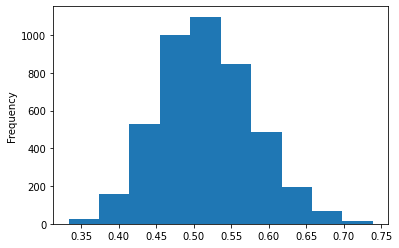

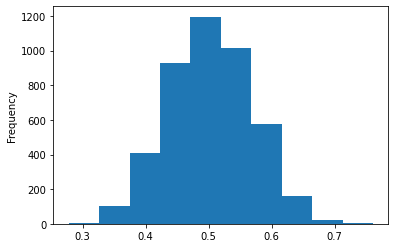

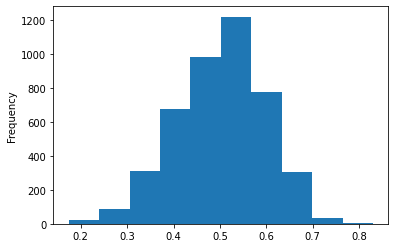

In [62]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [63]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
